In [21]:
import optuna
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from dask.distributed import wait
import time

In [2]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_rank
from optuna.visualization import plot_slice
from optuna.visualization import plot_timeline
import psutil
import warnings
import plotly

In [2]:
import dask
from dask.distributed import Scheduler, Client, LocalCluster
from dask.distributed import Client, LocalCluster
import dask.dataframe as dd
cluster = LocalCluster(n_workers=4,threads_per_worker=2)
client = Client(cluster)
client

In [ ]:
#client.close()

In [5]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import KFold, cross_val_score
def objective(trial):
    X, y = load_breast_cancer(return_X_y=True)
    params = {
        "n_estimators": 10,
        "verbosity": 0,
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 100.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 100.0, log=True),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "max_depth": trial.suggest_int("max_depth", 2, 10, step=1),
        # minimum child weight, larger the term more conservative the tree.
        "min_child_weight": trial.suggest_float(
            "min_child_weight", 1e-8, 100, log=True
        ),
        "learning_rate": trial.suggest_float("learning_rate", 1e-8, 1.0, log=True),
        # defines how selective algorithm is.
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy": "depthwise",
        "eval_metric": "logloss",
    }
    clf = xgb.XGBClassifier(**params)
    fold = KFold(n_splits=5, shuffle=True, random_state=0)
    score = cross_val_score(clf, X, y, cv=fold, scoring="accuracy")
    return score.mean()

In [15]:
def xgb_hpo():
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=5)
    print(study.best_value)
    return study

In [31]:
backend_storage = optuna.storages.InMemoryStorage()
dask_storage = optuna.integration.DaskStorage(storage=backend_storage)
def xgb_hpo_dask():
    study_dask = optuna.create_study(direction='maximize',storage=dask_storage,sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner())
    futures = [client.submit(study_dask.optimize, objective, n_trials=1, pure=False) for _ in range(5)]
    _ = wait(futures)
    print(study_dask.best_value)
    return study_dask

In [17]:
%%time 
study = xgb_hpo()

[I 2024-04-19 22:38:00,691] A new study created in memory with name: no-name-1311d5bf-fcce-4ebf-85a6-da95091c239f
[I 2024-04-19 22:38:01,561] Trial 0 finished with value: 0.6274025772395591 and parameters: {'lambda': 67.97305776669221, 'alpha': 4.765278645965258e-06, 'colsample_bytree': 0.8790244149224993, 'max_depth': 7, 'min_child_weight': 0.0001604288221987487, 'learning_rate': 2.7529953913455527e-07, 'gamma': 0.4658137977113674}. Best is trial 0 with value: 0.6274025772395591.
[I 2024-04-19 22:38:02,250] Trial 1 finished with value: 0.6274025772395591 and parameters: {'lambda': 36.92645665518304, 'alpha': 0.11174925956201374, 'colsample_bytree': 0.3858535065107327, 'max_depth': 9, 'min_child_weight': 3.443531558591988e-07, 'learning_rate': 0.00039739592397820107, 'gamma': 6.030320213304569e-08}. Best is trial 0 with value: 0.6274025772395591.
[I 2024-04-19 22:38:02,743] Trial 2 finished with value: 0.6274025772395591 and parameters: {'lambda': 3.6292109803562603e-07, 'alpha': 0.111

0.6274025772395591
CPU times: total: 8.25 s
Wall time: 3.33 s


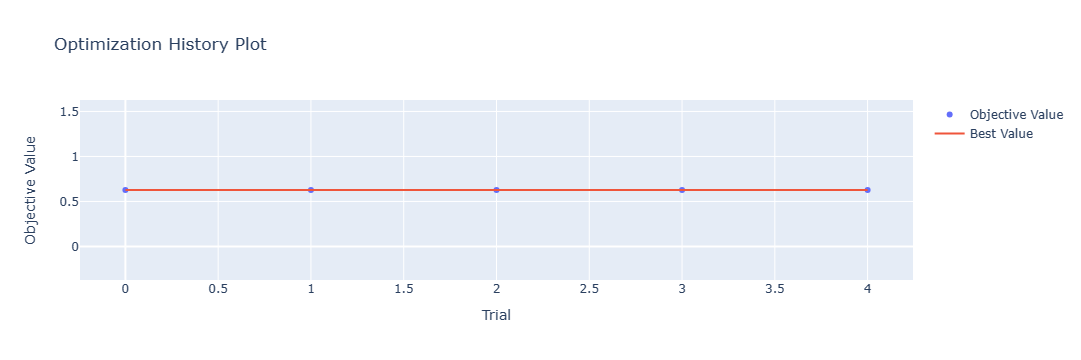

In [20]:
plot_optimization_history(study)

In [32]:
warnings.filterwarnings("ignore")
%time study_dask = xgb_hpo_dask()

0.9121409718987733
CPU times: total: 672 ms
Wall time: 1.31 s


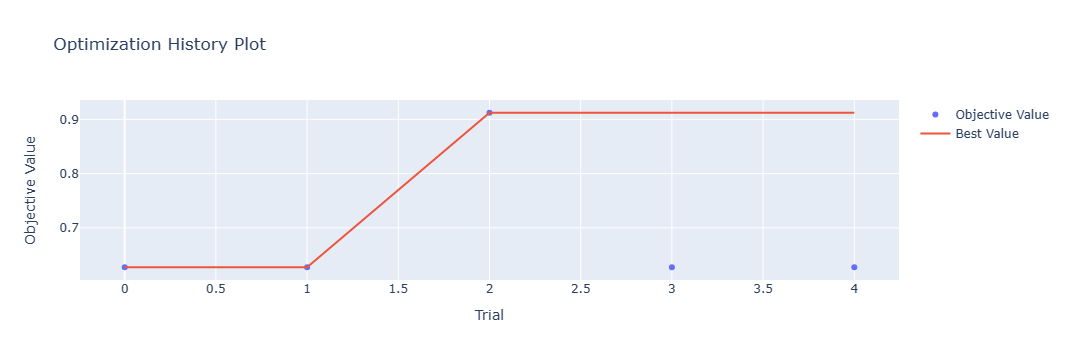

In [33]:
plot_optimization_history(study_dask)

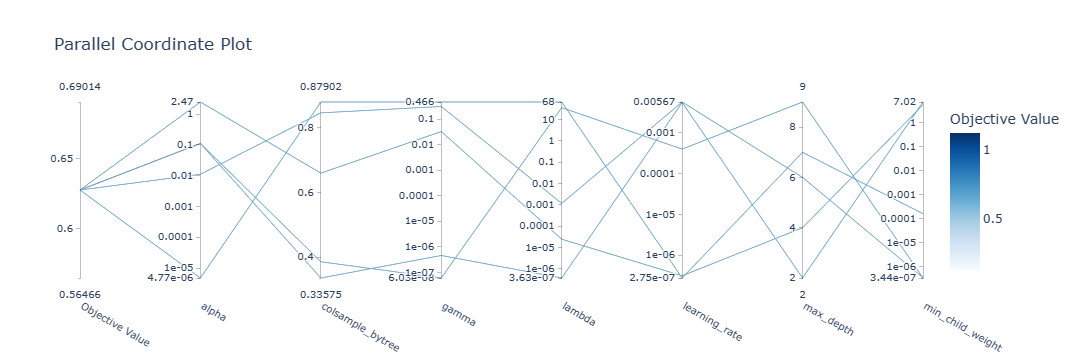

In [23]:
plot_parallel_coordinate(study)

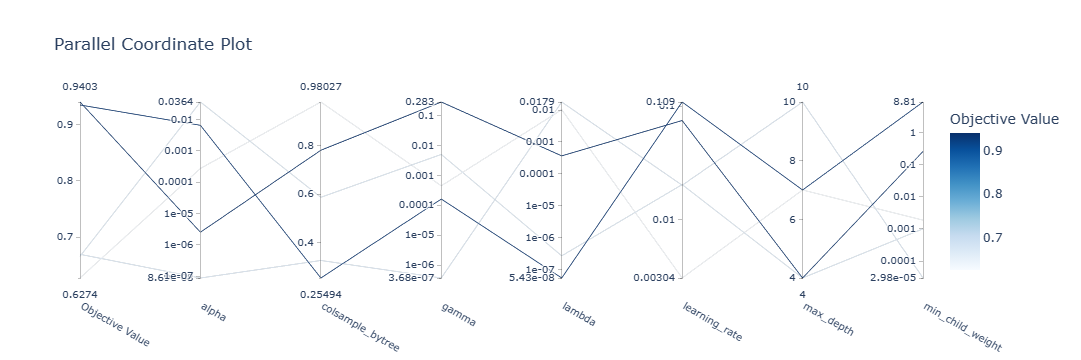

In [24]:
plot_parallel_coordinate(study_dask)

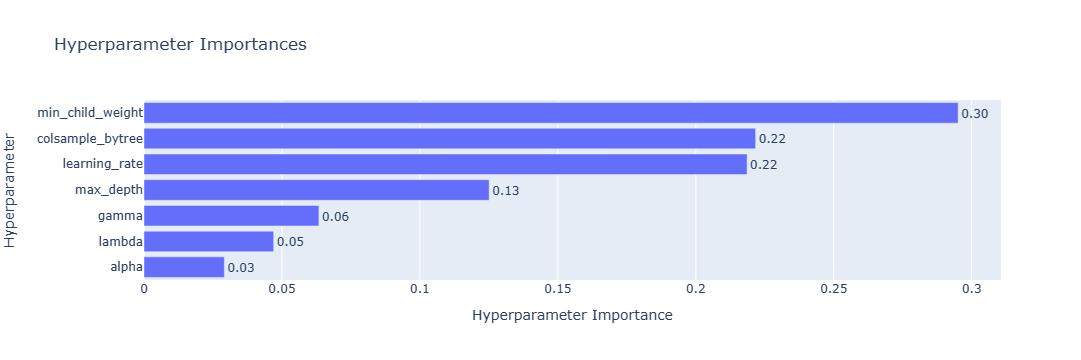

In [26]:
plot_param_importances(study_dask)

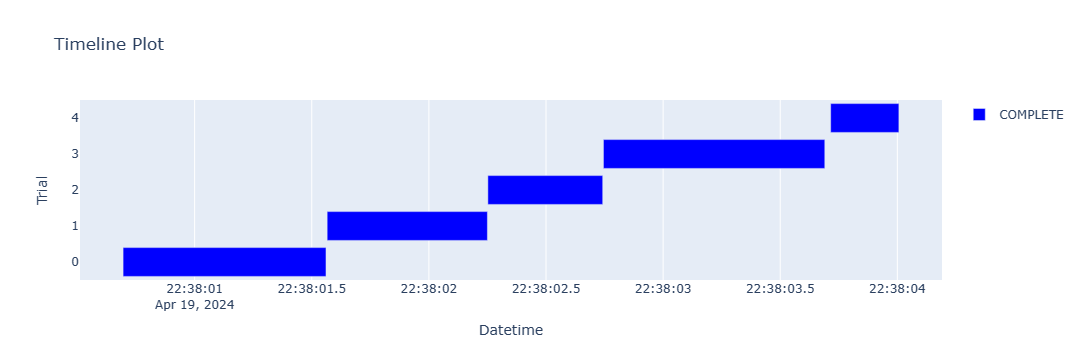

In [27]:
plot_timeline(study)

In [ ]:
from dask.diagnostics import visualize
visualize([prof, rprof, cprof])

In [14]:
import dask.array as da
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
a = da.random.random(size=(10000, 1000), chunks=(1000, 1000))
q, r = da.linalg.qr(a)
a2 = q.dot(r)

with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof,CacheProfiler() as cprof:
    out = a2.compute()

In [15]:
from dask.diagnostics import visualize
visualize([prof, rprof, cprof])

GridPlot(id='p6996', ...)

-----------------------------------------------------------------------------------------------------

In [ ]:
import pandas as pd
%time
data = pd.read_csv("Parking_Violations.csv")
data.head()

In [1]:
import dask.dataframe as dd
%time 
df = dd.read_csv('Parking_Violations.csv')
df = df.iloc[500:5000,:]